# Imports

In [34]:
from tqdm import tqdm
from typing import Tuple, List

import numpy as np

import torch
from torch import nn
from torch import functional as F

import matplotlib.pyplot as plt

# Data generation

In [35]:
def generate_correlated_gaussians(
    num_samples: int,
    dim: int,
    rho: float,
    device: str,
    mean: float = 0,
    std: float = 1,
    seed: int = 0,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    np.random.seed(seed)

    cov = np.block([
        [np.eye(dim), rho * np.eye(dim)],
        [rho * np.eye(dim), np.eye(dim)]
    ])
    mean_vec = np.zeros(2 * dim)
    samples = np.random.multivariate_normal(mean_vec, cov, size=num_samples)

    X = torch.tensor(samples[:, :dim], dtype=torch.float32).to(device)
    Y = torch.tensor(samples[:, dim:], dtype=torch.float32).to(device)

    return X, Y

In [36]:
def true_mutual_information(rho: float, dim: int) -> float:
    val = 1 - rho**2
    if val <= 0:
        return float('-inf')
    return -(dim / 2) * np.log(val)

# MINE

In [37]:
class MINE(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.input_dim = input_dim * 2
        self.MINE = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ELU(),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Linear(512, 1),
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return self.MINE(torch.cat((x, y), dim=1))

# Training scripts

In [44]:
def train_MINE(
    model: MINE,
    X: torch.Tensor,
    Y: torch.Tensor,
    n_epochs: int,
    batch_size: int,
    device: str,
    ema_decay: float = 0.01,
    ) -> None:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    ema_denominator = None
    n_samples = X.shape[0]

    for epoch in range(n_epochs):
        permutation = torch.randperm(n_samples, device=device)
        X_shuffled = X[permutation]
        Y_shuffled = Y[permutation]
        Y_marginal_shuffled = Y_shuffled[torch.randperm(n_samples, device=device)]

        for batch_idx in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[batch_idx:batch_idx+batch_size]
            Y_batch = Y_shuffled[batch_idx:batch_idx+batch_size]
            Y_marginal_batch = Y_marginal_shuffled[batch_idx:batch_idx+batch_size]

            joint_outputs = model(X_batch, Y_batch)
            marginal_outputs = model(X_batch, Y_marginal_batch)

            # Biased MI
            # log_denom_biased = torch.logsumexp(marginal_outputs, dim=0) - torch.log(
            #    torch.tensor(marginal_outputs.size(0), device=device, dtype=torch.float32)
            # )
            # MI_biased = joint_outputs.mean() - log_denom_biased


            # Unbiased MI with EMA
            exp_marginal_mean = torch.exp(marginal_outputs).mean()

            if ema_denominator is None:
                ema_denominator = exp_marginal_mean.detach()
            else:
                ema_denominator = (1 - ema_decay) * ema_denominator + ema_decay * exp_marginal_mean.detach()

            MI_unbiased = joint_outputs.mean() - torch.log(ema_denominator + 1e-8)

            loss_unbiased = -MI_unbiased
            optimizer.zero_grad()
            loss_unbiased.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        if epoch % 500 == 0:
            with torch.no_grad():
                joint_full = model(X, Y).mean()
                marginal_full = torch.exp(model(X, Y[torch.randperm(Y.size(0))])).mean()
                mi_estimate_for_print = (joint_full - torch.log(marginal_full + 1e-8)).item()
                print(f"Epoch {epoch}, MI (biased for print): {mi_estimate_for_print:.3f}")

In [45]:
def train_MINE_for_rhos(rhos: np.ndarray, num_samples: int, dim: int, n_epochs: int, batch_size: int, device: str) -> List:
    results = []
    for rho in tqdm(rhos):
        X, Y = generate_correlated_gaussians(num_samples, dim, rho, device)

        X, Y = X.to(device), Y.to(device)

        model = MINE(dim).to(device)
        train_MINE(model, X, Y, n_epochs, batch_size, device)

        with torch.no_grad():
            Y_marginal_eval = Y[torch.randperm(Y.size(0))]
            joint = model(X, Y).mean()
            marginal = torch.exp(model(X, Y_marginal_eval)).mean()
            mi_estimate = (joint - torch.log(marginal + 1e-8)).item()

        results.append({
            'rho': rho,
            'true_mi': true_mutual_information(rho, dim),
            'estimated_mi': mi_estimate
        })

    return results

# Main

In [46]:
NUM_SAMPLES = 10_000
DIM = 20
RHOS = np.linspace(-0.9, 0.9, 5)

N_EPOCHS = 10_000
BATCH_SIZE = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device that will be used for training is: {device}")

Device that will be used for training is: cuda


In [47]:
# Corrected the bias, removed the Gaussian noise
results = train_MINE_for_rhos(RHOS, NUM_SAMPLES, DIM, N_EPOCHS, BATCH_SIZE, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, MI estimate (biased for print): -0.009
Epoch 500, MI estimate (biased for print): -0.033
Epoch 1000, MI estimate (biased for print): -0.345
Epoch 1500, MI estimate (biased for print): -1.041
Epoch 2000, MI estimate (biased for print): -2.407
Epoch 2500, MI estimate (biased for print): -4.997
Epoch 3000, MI estimate (biased for print): -8.297
Epoch 3500, MI estimate (biased for print): -13.300
Epoch 4000, MI estimate (biased for print): -inf
Epoch 4500, MI estimate (biased for print): -inf
Epoch 5000, MI estimate (biased for print): -inf
Epoch 5500, MI estimate (biased for print): -inf
Epoch 6000, MI estimate (biased for print): -inf
Epoch 6500, MI estimate (biased for print): -inf
Epoch 7000, MI estimate (biased for print): -inf
Epoch 7500, MI estimate (biased for print): -inf
Epoch 8000, MI estimate (biased for print): -inf
Epoch 8500, MI estimate (biased for print): -inf
Epoch 9000, MI estimate (biased for print): -inf
Epoch 9500, MI estimate (biased for print): -inf


 20%|██        | 1/5 [03:05<12:23, 185.98s/it]

Epoch 0, MI estimate (biased for print): -0.007
Epoch 500, MI estimate (biased for print): -0.198
Epoch 1000, MI estimate (biased for print): -0.954
Epoch 1500, MI estimate (biased for print): -2.351
Epoch 2000, MI estimate (biased for print): -4.584
Epoch 2500, MI estimate (biased for print): -6.939
Epoch 3000, MI estimate (biased for print): -13.863
Epoch 3500, MI estimate (biased for print): -20.782
Epoch 4000, MI estimate (biased for print): -inf
Epoch 4500, MI estimate (biased for print): -inf
Epoch 5000, MI estimate (biased for print): -inf
Epoch 5500, MI estimate (biased for print): -inf
Epoch 6000, MI estimate (biased for print): -inf
Epoch 6500, MI estimate (biased for print): -inf
Epoch 7000, MI estimate (biased for print): -inf
Epoch 7500, MI estimate (biased for print): -inf
Epoch 8000, MI estimate (biased for print): -inf
Epoch 8500, MI estimate (biased for print): -inf
Epoch 9000, MI estimate (biased for print): -inf
Epoch 9500, MI estimate (biased for print): -inf


 40%|████      | 2/5 [06:11<09:17, 185.90s/it]

Epoch 0, MI estimate (biased for print): -0.010
Epoch 500, MI estimate (biased for print): -0.140
Epoch 1000, MI estimate (biased for print): -0.672
Epoch 1500, MI estimate (biased for print): -1.750
Epoch 2000, MI estimate (biased for print): -3.461
Epoch 2500, MI estimate (biased for print): -6.057
Epoch 3000, MI estimate (biased for print): -10.968
Epoch 3500, MI estimate (biased for print): -14.633
Epoch 4000, MI estimate (biased for print): -inf
Epoch 4500, MI estimate (biased for print): -inf
Epoch 5000, MI estimate (biased for print): -inf
Epoch 5500, MI estimate (biased for print): -inf
Epoch 6000, MI estimate (biased for print): -inf
Epoch 6500, MI estimate (biased for print): -inf
Epoch 7000, MI estimate (biased for print): -inf
Epoch 7500, MI estimate (biased for print): -inf
Epoch 8000, MI estimate (biased for print): -inf
Epoch 8500, MI estimate (biased for print): -inf
Epoch 9000, MI estimate (biased for print): -inf
Epoch 9500, MI estimate (biased for print): -inf


 60%|██████    | 3/5 [09:17<06:11, 185.76s/it]

Epoch 0, MI estimate (biased for print): -0.013
Epoch 500, MI estimate (biased for print): -0.269
Epoch 1000, MI estimate (biased for print): -1.147
Epoch 1500, MI estimate (biased for print): -3.021
Epoch 2000, MI estimate (biased for print): -5.983
Epoch 2500, MI estimate (biased for print): -8.625
Epoch 3000, MI estimate (biased for print): -16.238
Epoch 3500, MI estimate (biased for print): -19.502
Epoch 4000, MI estimate (biased for print): -inf
Epoch 4500, MI estimate (biased for print): -inf
Epoch 5000, MI estimate (biased for print): -inf
Epoch 5500, MI estimate (biased for print): -inf
Epoch 6000, MI estimate (biased for print): -inf
Epoch 6500, MI estimate (biased for print): -inf
Epoch 7000, MI estimate (biased for print): -inf
Epoch 7500, MI estimate (biased for print): -inf
Epoch 8000, MI estimate (biased for print): -inf
Epoch 8500, MI estimate (biased for print): -inf
Epoch 9000, MI estimate (biased for print): -inf
Epoch 9500, MI estimate (biased for print): -inf


 80%|████████  | 4/5 [12:23<03:05, 185.94s/it]

Epoch 0, MI estimate (biased for print): -0.005
Epoch 500, MI estimate (biased for print): -0.142
Epoch 1000, MI estimate (biased for print): -0.938
Epoch 1500, MI estimate (biased for print): -2.510
Epoch 2000, MI estimate (biased for print): -6.140
Epoch 2500, MI estimate (biased for print): -9.735
Epoch 3000, MI estimate (biased for print): -18.773
Epoch 3500, MI estimate (biased for print): -19.842
Epoch 4000, MI estimate (biased for print): -inf
Epoch 4500, MI estimate (biased for print): -inf
Epoch 5000, MI estimate (biased for print): -inf
Epoch 5500, MI estimate (biased for print): -inf
Epoch 6000, MI estimate (biased for print): -inf
Epoch 6500, MI estimate (biased for print): -inf
Epoch 7000, MI estimate (biased for print): -inf
Epoch 7500, MI estimate (biased for print): -inf
Epoch 8000, MI estimate (biased for print): -inf
Epoch 8500, MI estimate (biased for print): -inf
Epoch 9000, MI estimate (biased for print): -inf
Epoch 9500, MI estimate (biased for print): -inf


100%|██████████| 5/5 [15:29<00:00, 185.93s/it]


# Evaluation

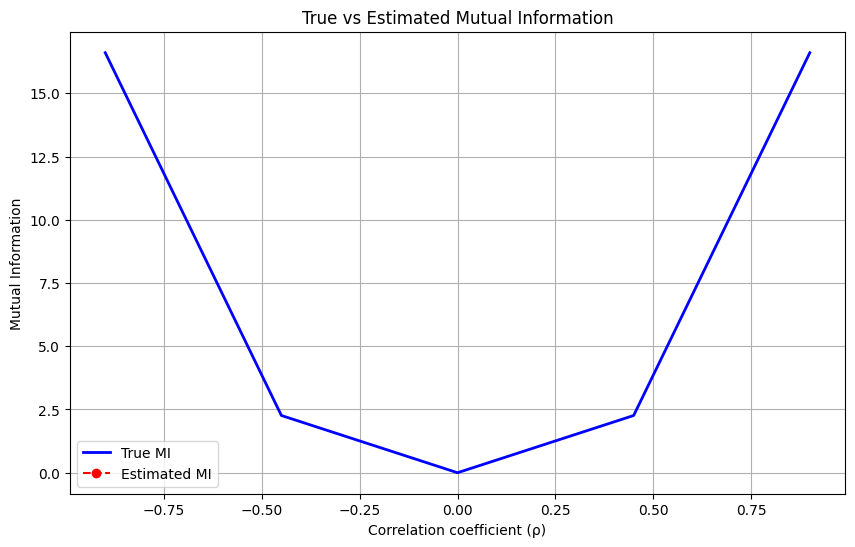

In [48]:
plt.figure(figsize=(10, 6))
plt.plot([r['rho'] for r in results], [r['true_mi'] for r in results],
         'b-', label='True MI', linewidth=2)
plt.plot([r['rho'] for r in results], [r['estimated_mi'] for r in results],
         'ro--', label='Estimated MI')
plt.xlabel('Correlation coefficient (ρ)')
plt.ylabel('Mutual Information')
plt.title('True vs Estimated Mutual Information')
plt.legend()
plt.grid(True)
plt.show()

[16.607312068216512,
 2.2627344432313743,
 -0.0,
 2.2627344432313756,
 16.607312068216512]